# Installs and Imports

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [53]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import requests

# Student Performance

/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: 

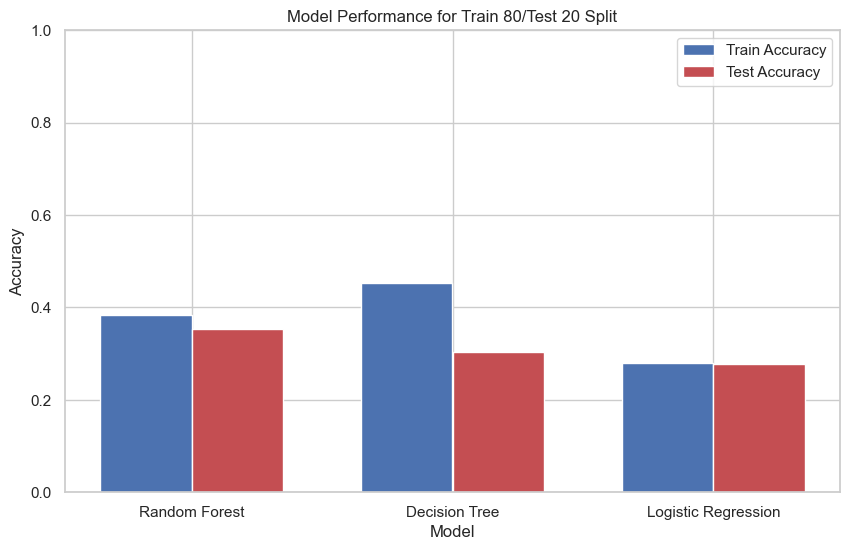

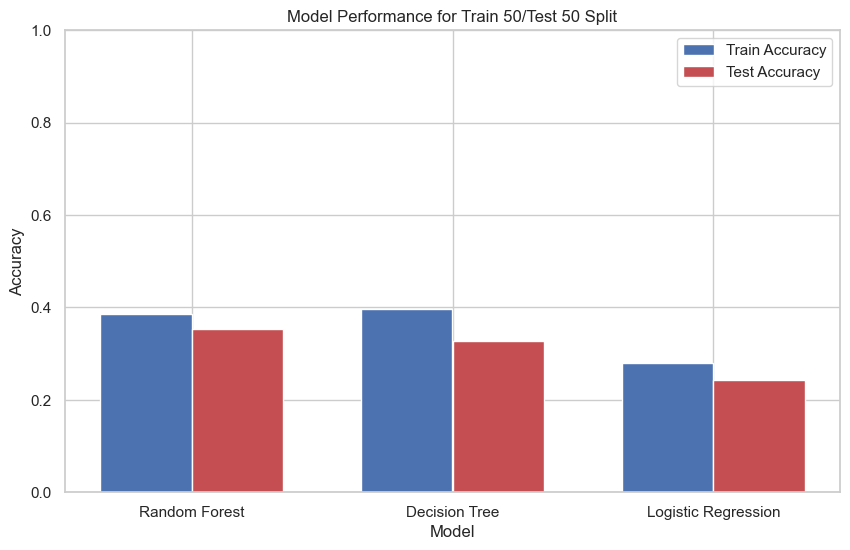

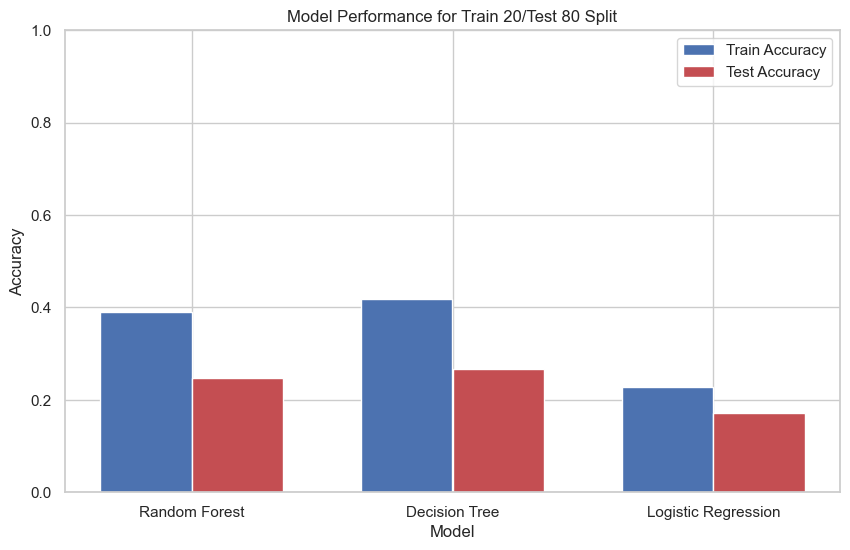

In [58]:
# Fetch the dataset using requests
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
response = requests.get(url, verify=False)

# Save the zip file
with open("student.zip", "wb") as f:
    f.write(response.content)

# Extract the zip file
import zipfile
with zipfile.ZipFile("student.zip", "r") as zip_ref:
    zip_ref.extractall("student_data")

# Load the dataset
df = pd.read_csv("student_data/student-mat.csv", sep=";")

# Preprocess the data
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('G3')

# Define preprocessing for numerical columns (scale)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X = df.drop('G3', axis=1)  # Features
y = df['G3']  # Target variable

# Define models and their hyperparameters for tuning with correct prefixes
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'model__n_estimators': [10, 50, 100], 'model__max_depth': [None, 10, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5]}
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'model__C': [0.1, 1, 10]}
    }
}

# Define partition sizes
partition_sizes = [(0.8, 0.2), (0.5, 0.5), (0.2, 0.8)]

# Store results
results = {}

# Evaluate each model on different partition sizes
for train_size, test_size in partition_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    results[f'Train {int(train_size*100)}/Test {int(test_size*100)}'] = {}
    
    for model_name, mp in model_params.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', mp['model'])])
        
        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, mp['params'], cv=StratifiedKFold(n_splits=5), scoring='accuracy', return_train_score=True)
        grid_search.fit(X_train, y_train)
        
        # Store best scores and parameters
        results[f'Train {int(train_size*100)}/Test {int(test_size*100)}'][model_name] = {
            'best_train_accuracy': grid_search.best_score_,
            'test_accuracy': grid_search.score(X_test, y_test),
            'best_params': grid_search.best_params_
        }

# Convert results to a DataFrame for pretty printing and plotting
formatted_results = []
for partition, models in results.items():
    for model_name, scores in models.items():
        formatted_results.append({
            'Partition': partition,
            'Model': model_name,
            'Train Accuracy': scores['best_train_accuracy'],
            'Test Accuracy': scores['test_accuracy']
        })

results_df = pd.DataFrame(formatted_results)

# Set the style for the plots
sns.set(style="whitegrid")

# Create a plot for each partition size
for partition in results_df['Partition'].unique():
    plt.figure(figsize=(10, 6))
    subset = results_df[results_df['Partition'] == partition]
    
    # Plotting separate bars for train and test accuracy
    bar_width = 0.35
    index = np.arange(len(subset))
    
    plt.bar(index, subset['Train Accuracy'], bar_width, label='Train Accuracy', color='b')
    plt.bar(index + bar_width, subset['Test Accuracy'], bar_width, label='Test Accuracy', color='r')
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance for {partition} Split')
    plt.xticks(index + bar_width / 2, subset['Model'])
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

# Car Evaluation

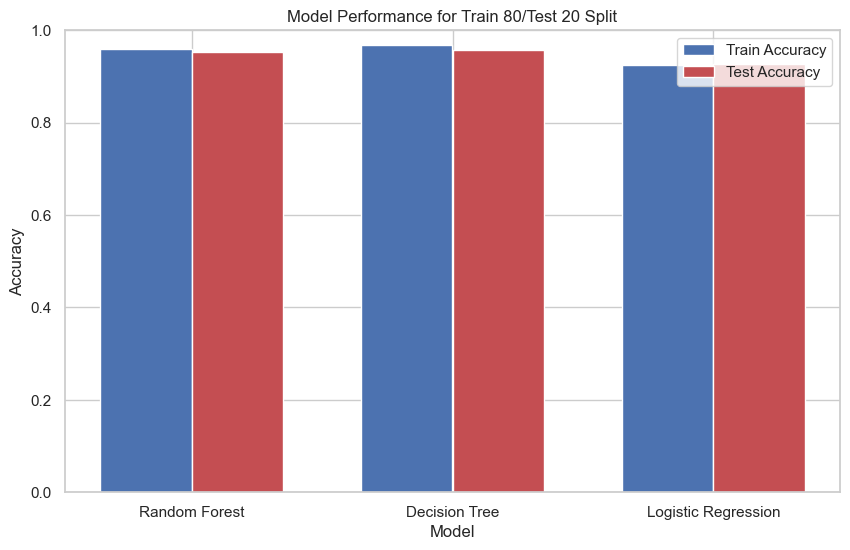

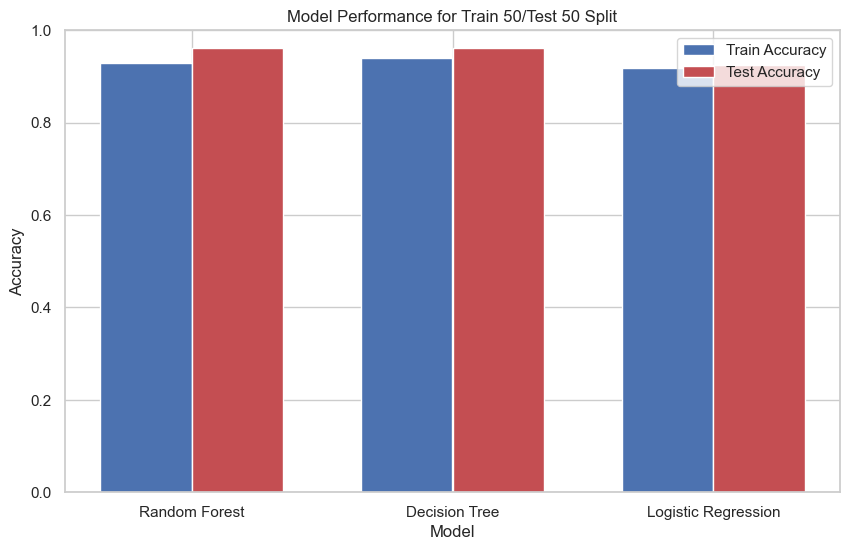

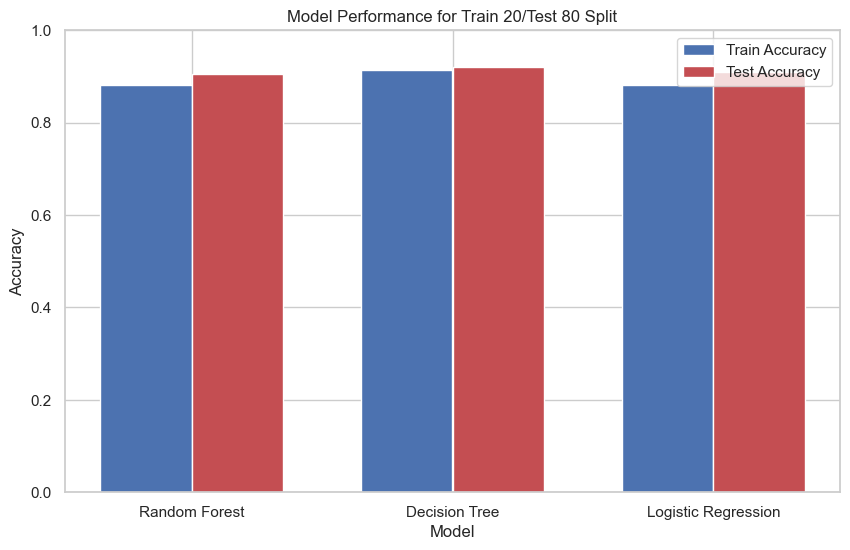

In [60]:
# Fetch the dataset using requests
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
response = requests.get(url, verify=False)

# Save the data to a CSV file
with open("car.data", "wb") as f:
    f.write(response.content)

# Load the dataset
column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv("car.data", names=column_names)

# Preprocess the data
categorical_cols = df.columns[:-1]  # All columns except 'class'

# Define preprocessing for categorical columns (one-hot encode)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Apply preprocessing
X = df.drop('class', axis=1)  # Features
y = df['class']  # Target variable

# Define models and their hyperparameters for tuning with correct prefixes
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'model__n_estimators': [10, 50, 100], 'model__max_depth': [None, 10, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5]}
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'model__C': [0.1, 1, 10]}
    }
}

# Define partition sizes
partition_sizes = [(0.8, 0.2), (0.5, 0.5), (0.2, 0.8)]

# Store results
results = {}

# Evaluate each model on different partition sizes
for train_size, test_size in partition_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    results[f'Train {int(train_size*100)}/Test {int(test_size*100)}'] = {}
    
    for model_name, mp in model_params.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', mp['model'])])
        
        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, mp['params'], cv=StratifiedKFold(n_splits=5), scoring='accuracy', return_train_score=True)
        grid_search.fit(X_train, y_train)
        
        # Store best scores and parameters
        results[f'Train {int(train_size*100)}/Test {int(test_size*100)}'][model_name] = {
            'best_train_accuracy': grid_search.best_score_,
            'test_accuracy': grid_search.score(X_test, y_test),
            'best_params': grid_search.best_params_
        }

# Convert results to a DataFrame for pretty printing and plotting
formatted_results = []
for partition, models in results.items():
    for model_name, scores in models.items():
        formatted_results.append({
            'Partition': partition,
            'Model': model_name,
            'Train Accuracy': scores['best_train_accuracy'],
            'Test Accuracy': scores['test_accuracy']
        })

results_df = pd.DataFrame(formatted_results)

# Set the style for the plots
sns.set(style="whitegrid")

# Create a plot for each partition size
for partition in results_df['Partition'].unique():
    plt.figure(figsize=(10, 6))
    subset = results_df[results_df['Partition'] == partition]
    
    # Plotting separate bars for train and test accuracy
    bar_width = 0.35
    index = np.arange(len(subset))
    
    plt.bar(index, subset['Train Accuracy'], bar_width, label='Train Accuracy', color='b')
    plt.bar(index + bar_width, subset['Test Accuracy'], bar_width, label='Test Accuracy', color='r')
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance for {partition} Split')
    plt.xticks(index + bar_width / 2, subset['Model'])
    plt.ylim(0, 1)
    plt.legend()
    plt.show()


# Estimation of Obesity Levels Based On Eating Habits and Physical Condition

In [64]:
# Fetch the dataset using requests
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00423/ObesityDataSet_raw_and_data_sinthetic.csv"
response = requests.get(url, verify=False)

# Save the data to a CSV file
with open("ObesityDataSet.csv", "wb") as f:
    f.write(response.content)

# Load the dataset
df = pd.read_csv("ObesityDataSet.csv")

# Preprocess the data
categorical_cols = df.select_dtypes(include=['object']).columns.drop('NObeyesdad')
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Define preprocessing for numerical columns (scale)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns (one-hot encode)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X = df.drop('NObeyesdad', axis=1)  # Features
y = df['NObeyesdad']  # Target variable

# Define models and their hyperparameters for tuning with correct prefixes
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'model__n_estimators': [10, 50, 100], 'model__max_depth': [None, 10, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5]}
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'model__C': [0.1, 1, 10]}
    }
}

# Define partition sizes
partition_sizes = [(0.8, 0.2), (0.5, 0.5), (0.2, 0.8)]

# Store results
results = {}

# Evaluate each model on different partition sizes
for train_size, test_size in partition_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=42)
    results[f'Train {int(train_size*100)}/Test {int(test_size*100)}'] = {}
    
    for model_name, mp in model_params.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', mp['model'])])
        
        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, mp['params'], cv=StratifiedKFold(n_splits=5), scoring='accuracy', return_train_score=True)
        grid_search.fit(X_train, y_train)
        
        # Store best scores and parameters
        results[f'Train {int(train_size*100)}/Test {int(test_size*100)}'][model_name] = {
            'best_train_accuracy': grid_search.best_score_,
            'test_accuracy': grid_search.score(X_test, y_test),
            'best_params': grid_search.best_params_
        }

# Convert results to a DataFrame for pretty printing and plotting
formatted_results = []
for partition, models in results.items():
    for model_name, scores in models.items():
        formatted_results.append({
            'Partition': partition,
            'Model': model_name,
            'Train Accuracy': scores['best_train_accuracy'],
            'Test Accuracy': scores['test_accuracy']
        })

results_df = pd.DataFrame(formatted_results)

# Set the style for the plots
sns.set(style="whitegrid")

# Create a plot for each partition size
for partition in results_df['Partition'].unique():
    plt.figure(figsize=(10, 6))
    subset = results_df[results_df['Partition'] == partition]
    
    # Plotting separate bars for train and test accuracy
    bar_width = 0.35
    index = np.arange(len(subset))
    
    plt.bar(index, subset['Train Accuracy'], bar_width, label='Train Accuracy', color='b')
    plt.bar(index + bar_width, subset['Test Accuracy'], bar_width, label='Test Accuracy', color='r')
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(f'Model Performance for {partition} Split')
    plt.xticks(index + bar_width / 2, subset['Model'])
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


KeyError: "['NObeyesdad'] not found in axis"